In [1]:
%load_ext autoreload
%autoreload 2   

# Node2vec

https://arxiv.org/abs/1607.00653

https://pytorch-geometric.readthedocs.io/en/latest/tutorial/shallow_node_embeddings.html

https://spotintelligence.com/2024/01/18/node2vec/

In [2]:
import torch
import torch.nn as nn
import networkx as nx
import numpy as np
from icecream import ic

from sklearn.decomposition import PCA
import torch.optim as optim

import random

import matplotlib.pyplot as plt


device = "mps" if torch.backends.mps.is_available() else "cpu"
ic(device);

ic| device: 'mps'


In [3]:
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


In [4]:
# Load the Zachary Karate Club graph
G = nx.karate_club_graph()
num_nodes = G.number_of_nodes()


def plot_graph(G, figsize=(10, 7)):
    club_dict = nx.get_node_attributes(G, "club")
    colors = [
        "lightblue" if club_dict[node] == "Mr. Hi" else "red" for node in G.nodes()
    ]
    plt.figure(figsize=figsize)
    nx.draw(
        G,
        pos=nx.spring_layout(G, seed=42),
        with_labels=True,
        node_color=colors,
        edge_color="gray",
        cmap="Set2",
    )


# plot_graph(G, figsize=(5, 5))

![](../resources/biased_rw.png)

in get_alias_edge: 
- src= t
- dst= w

In [5]:
def get_alias_edge(G, src, curr, p, q):
    """Compute transition probabilities for neighbors of 'dst' based on Node2Vec bias.
    dst: current node
    src: previous node
    p: return back to previous node. Lower p means backtracking is more likely.
    q: in-out param: explore new nodes (ratio of bfs[breadth-first search] to dfs[depth-first search]).
        lower q means more exploration of distant nodes
    """
    unnormalized_probs = []
    for neighbor in G[curr]:
        if neighbor == src:
            weight = 1.0 / p
        elif G.has_edge(
            neighbor, src
        ):  # if neighbor is a neighbor of src (above ex: s1 is neighbor of t)
            weight = 1.0
        else:
            weight = 1.0 / q
        unnormalized_probs.append(weight)
    norm_const = sum(unnormalized_probs)
    normalized_probs = [w / norm_const for w in unnormalized_probs]
    return list(G[curr]), normalized_probs


def node2vec_walk(G, start, walk_length, p, q):
    """Generate a random walk starting from the given node."""
    walk = [start]
    while len(walk) < walk_length:
        cur = walk[-1]
        neighbors = list(G.neighbors(cur))
        if len(neighbors) == 0:
            break
        if len(walk) == 1:
            next_node = random.choice(neighbors)
        else:
            prev = walk[-2]
            candidates, probs = get_alias_edge(G, src=prev, curr=cur, p=p, q=q)
            next_node = random.choices(candidates, weights=probs, k=1)[0]
        walk.append(next_node)
    return walk


ic.enable()
nodes = list(G.nodes())
node = nodes[0]
ic(node)
for i in range(10):
    walk = node2vec_walk(G, start=node, walk_length=10, p=1, q=1)
    ic(walk)

ic| node: 0
ic| walk: [0, 4, 0, 5, 0, 13, 3, 13, 0, 7]
ic| walk: [0, 1, 0, 4, 6, 5, 10, 5, 6, 4]
ic| walk: [0, 10, 5, 0, 17, 1, 7, 0, 31, 25]
ic| walk: [0, 3, 2, 7, 1, 3, 0, 8, 0, 21]
ic| walk: [0, 3, 7, 3, 7, 3, 7, 2, 0, 4]
ic| walk: [0, 11, 0, 19, 33, 19, 1, 21, 0, 6]
ic| walk: [0, 10, 5, 10, 0, 12, 3, 1, 13, 1]
ic| walk: [0, 8, 32, 31, 32, 14, 32, 15, 32, 14]
ic| walk: [0, 12, 0, 8, 33, 27, 2, 1, 19, 1]
ic| walk: [0, 19, 33, 19, 0, 31, 28, 2, 0, 2]


# decompose walk

![](../resources/zachary.png)

In [6]:
start = 0
walk = [start]
p = 1
q = 0.5
walk_length = 2
for i in range(walk_length):
    cur = walk[-1]
    neighbors = list(G.neighbors(cur))
    ic(len(neighbors))
    ic(neighbors)

    if len(neighbors) == 0:
        break
    if len(walk) == 1:
        next_node = random.choice(neighbors)
    else:
        prev = walk[-2]
        candidates, probs = get_alias_edge(G, prev, cur, p, q)
        ic(candidates)
        ic(probs)
        next_node = random.choices(candidates, weights=probs, k=1)[0]
    ic(next_node)
    walk.append(next_node)
    ic(walk)

ic| len(neighbors): 16
ic| neighbors: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]
ic| next_node: 6
ic| walk: [0, 6]
ic| len(neighbors): 4
ic| neighbors: [0, 4, 5, 16]
ic| candidates: [0, 4, 5, 16]
ic| probs: [0.2, 0.2, 0.2, 0.4]
ic| next_node: 16
ic| walk: [0, 6, 16]


In [7]:
# Generate random walks for all nodes

# Node2Vec parameters
p = 1
q = 0.2
walk_length = 8
num_walks = 20
walks = []
for _ in range(num_walks):
    nodes = list(G.nodes())
    random.shuffle(nodes)
    for node in nodes:
        walk = node2vec_walk(G, node, walk_length, p, q)
        walks.append(walk)


In [8]:
len(walks[:])

680

In [9]:
window_size = 2
embedding_dim = 16
num_negative_samples = 5


# A walk represents a sequence of nodes traversed in the graph.
# For each node (called target) in a walk, the algorithm creates training pairs
# with surrounding nodes within a window of size window_size.
# window size = 2 means that for each target node,
# the algorithm will consider the two nodes before and two nodes after it in the walk.


def gen_walk_pairs(walk, window_size):
    walk_pairs = []
    for i, target in enumerate(walk):
        start = max(0, i - window_size)
        end = min(len(walk), i + window_size + 1)
        ic(i, target, start, end)
        for j in range(start, end):
            if i != j:
                ic("pair", target, j, walk[j])
                if walk[j] != target:  # Avoid pairs of the same node
                    walk_pairs.append((target, walk[j]))

    return walk_pairs


ic.enable()
w = walks[0]
ic(window_size)
w = [0, 2, 3, 2, 5, 2, 5]
ic(w)
walk_pairs = gen_walk_pairs(w, window_size)


ic| window_size: 2
ic| w: [0, 2, 3, 2, 5, 2, 5]
ic| i: 0, target: 0, start: 0, end: 3
ic| 'pair', target: 0, j: 1, walk[j]: 2
ic| 'pair', target: 0, j: 2, walk[j]: 3
ic| i: 1, target: 2, start: 0, end: 4
ic| 'pair', target: 2, j: 0, walk[j]: 0
ic| 'pair', target: 2, j: 2, walk[j]: 3
ic| 'pair', target: 2, j: 3, walk[j]: 2
ic| i: 2, target: 3, start: 0, end: 5
ic| 'pair', target: 3, j: 0, walk[j]: 0
ic| 'pair', target: 3, j: 1, walk[j]: 2
ic| 'pair', target: 3, j: 3, walk[j]: 2
ic| 'pair', target: 3, j: 4, walk[j]: 5
ic| i: 3, target: 2, start: 1, end: 6
ic| 'pair', target: 2, j: 1, walk[j]: 2
ic| 'pair', target: 2, j: 2, walk[j]: 3
ic| 'pair', target: 2, j: 4, walk[j]: 5
ic| 'pair', target: 2, j: 5, walk[j]: 2
ic| i: 4, target: 5, start: 2, end: 7
ic| 'pair', target: 5, j: 2, walk[j]: 3
ic| 'pair', target: 5, j: 3, walk[j]: 2
ic| 'pair', target: 5, j: 5, walk[j]: 2
ic| 'pair', target: 5, j: 6, walk[j]: 5
ic| i: 5, target: 2, start: 3, end: 7
ic| 'pair', target: 2, j: 3, walk[j]: 2
ic| 

In [10]:
walk_pairs[:]

[(0, 2),
 (0, 3),
 (2, 0),
 (2, 3),
 (3, 0),
 (3, 2),
 (3, 2),
 (3, 5),
 (2, 3),
 (2, 5),
 (5, 3),
 (5, 2),
 (5, 2),
 (2, 5),
 (2, 5),
 (5, 2)]

In [11]:
ic.disable()
pairs = []
for walk in walks:
    walk_pairs = gen_walk_pairs(walk, window_size)
    pairs.extend(walk_pairs)

pairs = np.array(pairs)
len(pairs)


16588

In [12]:
from collections import Counter

# Compute pair occurrences
pair_counts = Counter(tuple(pair) for pair in pairs)
pair_counts
# Display the results
print(f"Total number of pairs: {len(pairs)}")
print(f"Number of unique pairs: {len(pair_counts)}")
print("\nTop 10 most frequent pairs:")
for pair, count in pair_counts.most_common(10):
    print(f"Pair {pair}: {count} occurrences")

# You can also create a dictionary for easy lookup
pair_dict = dict(pair_counts)
print(f"\nExample lookups:")
print(f"Pair (0, 1) occurs {pair_dict.get((0, 1), 0)} times")
print(f"Pair (1, 0) occurs {pair_dict.get((1, 0), 0)} times")

# Distribution of pair frequencies
freq_distribution = Counter(pair_counts.values())
print(f"\nFrequency distribution:")
for freq, count in sorted(freq_distribution.items()):
    print(f"{count} pairs occur {freq} time(s)")


Total number of pairs: 16588
Number of unique pairs: 682

Top 10 most frequent pairs:
Pair (32, 33): 172 occurrences
Pair (33, 32): 172 occurrences
Pair (33, 2): 125 occurrences
Pair (2, 33): 125 occurrences
Pair (6, 4): 108 occurrences
Pair (4, 6): 108 occurrences
Pair (0, 1): 106 occurrences
Pair (1, 0): 106 occurrences
Pair (5, 6): 103 occurrences
Pair (6, 5): 103 occurrences

Example lookups:
Pair (0, 1) occurs 106 times
Pair (1, 0) occurs 106 times

Frequency distribution:
26 pairs occur 1 time(s)
54 pairs occur 2 time(s)
58 pairs occur 3 time(s)
38 pairs occur 4 time(s)
52 pairs occur 5 time(s)
32 pairs occur 6 time(s)
34 pairs occur 7 time(s)
38 pairs occur 8 time(s)
32 pairs occur 9 time(s)
16 pairs occur 10 time(s)
28 pairs occur 11 time(s)
4 pairs occur 12 time(s)
30 pairs occur 13 time(s)
8 pairs occur 14 time(s)
6 pairs occur 15 time(s)
4 pairs occur 16 time(s)
2 pairs occur 17 time(s)
2 pairs occur 19 time(s)
4 pairs occur 21 time(s)
4 pairs occur 22 time(s)
4 pairs occur 

In [21]:
pair_dict.get((8, 9))

9

![](../resources/loss_rw.png)

In [14]:
ic.enable()
ic(num_negative_samples)
batch_size = 2
negative_batch = torch.LongTensor(
    np.random.randint(0, num_nodes, size=(batch_size, num_negative_samples))
).to(device)
ic(negative_batch);

ic| num_negative_samples: 5
ic| negative_batch: tensor([[ 2, 21,  1, 23, 29],
                            [ 1, 20, 32, 11, 21]], device='mps:0')


In [15]:
# Define the Node2Vec Skip-Gram model
class Node2Vec(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(Node2Vec, self).__init__()
        self.in_embeddings = nn.Embedding(num_nodes, embedding_dim)
        self.out_embeddings = nn.Embedding(num_nodes, embedding_dim)
        nn.init.xavier_uniform_(self.in_embeddings.weight)
        nn.init.xavier_uniform_(self.out_embeddings.weight)

    def forward(self, target, context, negative):
        ic(target.shape, context.shape, negative.shape)
        embed_target = self.in_embeddings(target)  # (batch, embedding_dim)
        embed_context = self.out_embeddings(context)  # (batch, embedding_dim)
        ic(embed_target.shape, embed_context.shape)
        score = torch.sum(embed_target * embed_context, dim=1)
        ic(score)
        log_target = torch.log(torch.sigmoid(score) + 1e-10)
        ic(log_target)

        embed_negative = self.out_embeddings(
            negative
        )  # (batch, num_negative, embedding_dim)
        ic(embed_negative.shape)
        # we could use matmul, but bmm has been specially optimized for batch processing
        ic(torch.bmm(embed_negative, embed_target.unsqueeze(2)))
        neg_score = torch.bmm(embed_negative, embed_target.unsqueeze(2)).squeeze()
        log_negative = torch.sum(torch.log(torch.sigmoid(-neg_score) + 1e-10), dim=1)

        loss = -(log_target + log_negative)
        ic(loss)
        return loss.mean()


ic(embedding_dim, num_nodes)
model = Node2Vec(num_nodes, embedding_dim).to(device)

model.forward(
    target=torch.LongTensor([0, 1]).to(device),
    context=torch.LongTensor([1, 2]).to(device),
    negative=torch.LongTensor([[3, 2, 4], [4, 6, 5]]).to(device),
)


ic| embedding_dim: 16, num_nodes: 34
ic| target.shape: torch.Size([2])
    context.shape: torch.Size([2])
    negative.shape: torch.Size([2, 3])
ic| embed_target.shape: torch.Size([2, 16])
    embed_context.shape: torch.Size([2, 16])
ic| score: tensor([-0.0855,  0.0556], device='mps:0', grad_fn=<SumBackward1>)
ic| log_target: tensor([-0.7368, -0.6658], device='mps:0', grad_fn=<LogBackward0>)
ic| embed_negative.shape: torch.Size([2, 3, 16])
ic| torch.bmm(embed_negative, embed_target.unsqueeze(2)): tensor([[[ 0.0521],
                                                                   [-0.0259],
                                                                   [ 0.2595]],
                                                          
                                                                  [[ 0.1936],
                                                                   [-0.0578],
                                                                   [ 0.1921]]], device='mps:0', grad_fn=<B

tensor(2.9434, device='mps:0', grad_fn=<MeanBackward0>)

### Characterize the Spatial Properties of embeddings

https://medium.com/data-science-collective/whats-happening-to-embeddings-during-training-338c420705e5

To start the study, we first need some indicators or metrics that characterize the spatial properties of embeddings. Among the limited literature, the following measures were selected:

- Gini Index: Measures inequality of values, i.e., if the information in the vector is concentrated in a few dimensions.
- Vector Entropy: Measures distributional uncertainty that reveals how uniformly the embedding uses its dimensions.
- Hoyer Sparsity: Measures how many dimensions are effectively utilized.
- Spectral Entropy: Gives a frequency-domain view that reflects how smooth or noisy the embedding is.

In [16]:
import numpy as np


def gini(x):
    """Compute the Gini coefficient of a vector."""
    x = np.abs(x.flatten()) + 1e-12  # Avoid division by zero
    x_sorted = np.sort(x)
    n = len(x)
    cumulative = np.cumsum(x_sorted)
    gini_coeff = (n + 1 - 2 * np.sum(cumulative) / cumulative[-1]) / n
    return gini_coeff


def vector_entropy(x):
    """Compute entropy of normalized absolute vector components."""
    x = np.abs(x.flatten()) + 1e-12
    p = x / np.sum(x)
    return -np.sum(p * np.log(p))


def hoyer_sparsity(x):
    """Compute Hoyer's sparsity measure of a vector."""
    x = np.abs(x.flatten())
    n = len(x)
    l1 = np.sum(x)
    l2 = np.sqrt(np.sum(x**2))
    if l1 == 0:
        return 0.0
    return (np.sqrt(n) - (l1 / l2)) / (np.sqrt(n) - 1)


def spectral_entropy(E):
    """Compute spectral entropy from an embedding matrix E (rows = vectors)."""
    # Compute covariance matrix
    cov = np.cov(E, rowvar=False)
    # Compute eigenvalues
    eigvals = np.linalg.eigvalsh(cov)
    eigvals = np.clip(eigvals, a_min=1e-12, a_max=None)  # avoid log(0)
    p = eigvals / np.sum(eigvals)
    return -np.sum(p * np.log(p))

In [17]:
model = Node2Vec(num_nodes, embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
# Training loop
num_epochs = 100
batch_size = 64
num_batches = len(pairs) // batch_size + 1
ic.disable()
for epoch in range(num_epochs):
    np.random.shuffle(pairs)
    epoch_loss = 0
    for i in range(0, len(pairs), batch_size):
        batch = pairs[i : i + batch_size]
        ic(batch.shape, batch[:, 0].shape)
        target_batch = torch.LongTensor(batch[:, 0]).to(device)
        context_batch = torch.LongTensor(batch[:, 1]).to(device)
        # Nb: there is no guarantee that the negative samples are actually negative (not connected to target nodes)
        # to be perfectly negative, For each target node, sample from nodes that are not its neighbors.
        # Not perfect by still works (just noiser.)
        negative_batch = torch.LongTensor(
            np.random.randint(0, num_nodes, size=(len(batch), num_negative_samples))
        ).to(device)

        optimizer.zero_grad()
        loss = model(target_batch, context_batch, negative_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss / num_batches:.4f}")
        embeddings = model.in_embeddings.weight.data.cpu().numpy()
        gini_score = round(float(np.mean(list(map(gini, embeddings)))), 4)
        hoyer_sparsity_score = round(
            float(np.mean(list(map(hoyer_sparsity, embeddings)))), 4
        )
        vector_entropy_score = round(
            float(np.mean(list(map(vector_entropy, embeddings)))), 4
        )
        spectral_entropy_score = round(float(spectral_entropy(embeddings)), 4)
        print(
            f"Gini: {gini_score}, Hoyer's Sparsity: {hoyer_sparsity_score}, Vector Entropy: {vector_entropy_score}, Spectral Entropy: {spectral_entropy_score}"
        )


Epoch 10, Loss: 1.9654
Gini: 0.391, Hoyer's Sparsity: 0.2496, Vector Entropy: 2.505, Spectral Entropy: 2.3241
Epoch 20, Loss: 1.9638
Gini: 0.397, Hoyer's Sparsity: 0.2579, Vector Entropy: 2.4978, Spectral Entropy: 2.3464
Epoch 30, Loss: 1.9648
Gini: 0.3998, Hoyer's Sparsity: 0.2608, Vector Entropy: 2.4928, Spectral Entropy: 2.3464
Epoch 40, Loss: 1.9664
Gini: 0.4003, Hoyer's Sparsity: 0.2618, Vector Entropy: 2.4901, Spectral Entropy: 2.3452
Epoch 50, Loss: 1.9711
Gini: 0.4071, Hoyer's Sparsity: 0.2687, Vector Entropy: 2.4781, Spectral Entropy: 2.3466
Epoch 60, Loss: 1.9587
Gini: 0.4054, Hoyer's Sparsity: 0.2688, Vector Entropy: 2.4818, Spectral Entropy: 2.3452
Epoch 70, Loss: 1.9676
Gini: 0.4135, Hoyer's Sparsity: 0.2762, Vector Entropy: 2.4667, Spectral Entropy: 2.3457
Epoch 80, Loss: 1.9597
Gini: 0.4097, Hoyer's Sparsity: 0.2741, Vector Entropy: 2.4718, Spectral Entropy: 2.3425
Epoch 90, Loss: 1.9582
Gini: 0.4154, Hoyer's Sparsity: 0.2807, Vector Entropy: 2.4615, Spectral Entropy: 2.


Learned embeddings:
Node 0: [-0.49955845 -0.49000397  0.14092606 -1.245069   -1.6117195   0.37397334
 -0.06207275  0.04993914 -0.42798844  0.16497685 -0.43916345 -0.28619114
 -0.06202657  0.02914826 -0.3092344  -0.22108014]
Node 1: [-0.24376695 -1.0860714  -0.20961866  0.6973329  -1.4602368  -0.2323935
 -0.32413045  0.7493487   0.9408256  -0.25752327 -1.0320985  -0.23702824
 -0.6682335   0.3731515  -0.07395089 -0.42440757]
Node 2: [-0.44409862  0.10775401 -0.24064426 -0.14203179 -0.7119882  -1.2748002
  0.02933224 -0.20920976 -0.2023342   0.32852075 -0.26651543 -1.1047646
 -0.95364785  0.1063213   0.49263808 -0.29491976]
Node 3: [ 0.84697187 -0.3154922  -0.3910283  -1.1903341  -0.99452496 -1.0143274
 -0.614738    0.83738637  0.29638138 -0.5774908  -0.70874375  0.58410937
 -1.2204968   0.33784285 -0.41666165  0.03893142]
Node 4: [ 0.17620698 -1.5480744  -0.10772036 -0.7095298  -0.85497147 -0.6124968
  0.22273368  1.5285254   0.08714233 -0.81456393 -0.10654567  0.22620083
  0.95452195 -

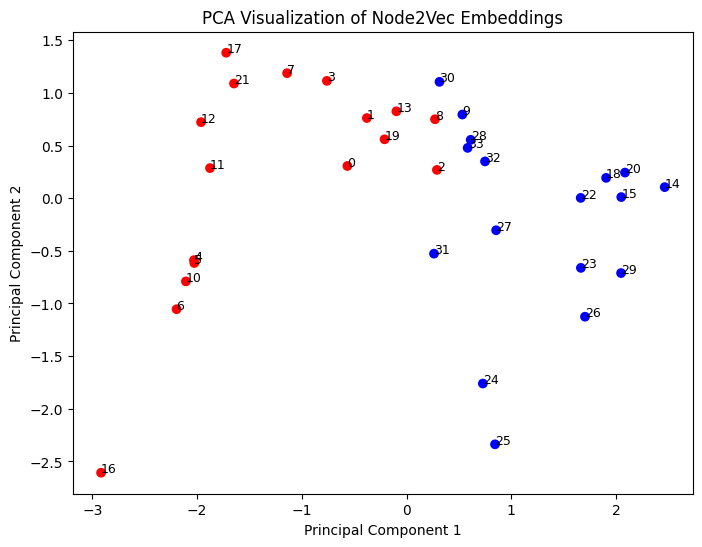

In [18]:
# Retrieve learned embeddings
embeddings = model.in_embeddings.weight.data.cpu().numpy()
print("\nLearned embeddings:")
for node in range(num_nodes):
    print(f"Node {node}: {embeddings[node]}")

# Use PCA to reduce the embeddings to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Create colors list based on club membership: red for 'Mr. Hi', blue for others.
colors = []
for node in range(num_nodes):
    club = G.nodes[node]["club"]
    colors.append("red" if club == "Mr. Hi" else "blue")

# Plotting the PCA visualization
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)
for i in range(num_nodes):
    plt.annotate(str(i), (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)
plt.title("PCA Visualization of Node2Vec Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## gemini

Solution suggested by gemini

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from tqdm import tqdm


# Load the Zachary Karate Club graph
def load_karate_graph():
    """
    Loads the Zachary Karate Club graph from NetworkX.

    Returns:
        nx.Graph: The Karate Club graph.
    """
    G = nx.karate_club_graph()
    return G


# Convert NetworkX graph to adjacency list
def graph_to_adj_list(graph):
    """
    Converts a NetworkX graph to an adjacency list representation.

    Args:
        graph (nx.Graph): The input graph.

    Returns:
        dict: An adjacency list where keys are nodes and values are lists of neighbors.
    """
    adj_list = defaultdict(list)
    for node in graph.nodes():
        adj_list[node] = list(graph.neighbors(node))
    return adj_list


# Generate random walk
def generate_random_walk(graph, start_node, walk_length, p, q):
    """
    Generates a random walk starting from a given node.  This implementation
    correctly handles the edge weights (p and q) for the walk.

    Args:
        graph (nx.Graph): The input graph.
        start_node (int): The starting node for the random walk.
        walk_length (int): The length of the random walk.
        p (float): The return parameter.
        q (float): The in-out parameter.

    Returns:
        list: A list of nodes representing the random walk.
    """
    walk = [start_node]
    for _ in range(walk_length - 1):
        current_node = walk[-1]
        neighbors = list(graph.neighbors(current_node))
        if not neighbors:
            break  # Handle disconnected nodes
        if len(walk) == 1:
            # Start node case: sample directly from neighbors
            next_node = random.choice(neighbors)
            walk.append(next_node)
        else:
            # Subsequent step case: consider p and q
            previous_node = walk[-2]
            probabilities = []
            for neighbor in neighbors:
                if neighbor == previous_node:
                    probabilities.append(1 / p)  # Return probability
                elif graph.has_edge(previous_node, neighbor):
                    probabilities.append(1)  # Neighboring node
                else:
                    probabilities.append(1 / q)  # Non-neighboring node
            # Normalize probabilities to sum to 1
            probabilities = [prob / sum(probabilities) for prob in probabilities]
            # Use the probabilities to select the next node.
            next_node = random.choices(neighbors, probabilities)[0]
            walk.append(next_node)
    return walk


# Generate multiple random walks
def generate_walks(graph, num_walks, walk_length, p, q):
    """
    Generates multiple random walks for each node in the graph.

    Args:
        graph (nx.Graph): The input graph.
        num_walks (int): The number of random walks per node.
        walk_length (int): The length of each random walk.
        p (float): The return parameter.
        q (float): The in-out parameter.

    Returns:
        list: A list of lists, where each inner list is a random walk.
    """
    walks = []
    nodes = list(graph.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)  # Shuffle for each iteration
        for node in nodes:
            walk = generate_random_walk(graph, node, walk_length, p, q)
            walks.append(walk)
    return walks


# Skip-gram model with negative sampling
class SkipGramModel(torch.nn.Module):
    """
    Skip-gram model for learning node embeddings.  This implementation
    uses PyTorch and includes proper initialization.
    """

    def __init__(self, num_nodes, embedding_dim):
        """
        Initializes the Skip-gram model.

        Args:
            num_nodes (int): The number of nodes in the graph.
            embedding_dim (int): The dimensionality of the node embeddings.
        """
        super(SkipGramModel, self).__init__()
        self.embedding_u = torch.nn.Embedding(
            num_nodes, embedding_dim
        )  # Target embeddings
        self.embedding_v = torch.nn.Embedding(
            num_nodes, embedding_dim
        )  # Context embeddings

        # Initialize embeddings using a small uniform distribution
        init_range = 0.5 / embedding_dim
        self.embedding_u.weight.data.uniform_(-init_range, init_range)
        self.embedding_v.weight.data.uniform_(
            -0, 0
        )  # init_range, init_range) # Initializing to 0 can sometimes help

    def forward(self, center_nodes, context_nodes, negative_samples):
        """
        Computes the forward pass of the Skip-gram model.

        Args:
            center_nodes (torch.Tensor): Tensor of center node indices.
            context_nodes (torch.Tensor): Tensor of context node indices.
            negative_samples (torch.Tensor): Tensor of negative sample indices.

        Returns:
            torch.Tensor: The loss value.
        """
        # Get embeddings for center nodes
        u_embeddings = self.embedding_u(center_nodes)  # (batch_size, embedding_dim)

        # Get embeddings for context nodes
        v_embeddings = self.embedding_v(context_nodes)  # (batch_size, embedding_dim)

        # Compute the positive log-likelihood
        positive_scores = torch.sum(u_embeddings * v_embeddings, dim=1)  # (batch_size,)
        positive_loss = -torch.mean(torch.log(torch.sigmoid(positive_scores)))

        # Get embeddings for negative samples
        negative_embeddings = self.embedding_v(
            negative_samples
        )  # (batch_size, num_negative_samples, embedding_dim)

        # Compute the negative log-likelihood
        negative_scores = torch.bmm(
            negative_embeddings, u_embeddings.unsqueeze(2)
        ).squeeze(2)  # (batch_size, num_negative_samples)
        negative_loss = -torch.mean(torch.log(torch.sigmoid(-negative_scores)))

        # Combine positive and negative losses
        loss = positive_loss + negative_loss
        return loss


def generate_negative_samples(walks, num_nodes, window_size, num_negative_samples):
    """
    Generates negative samples for each center node and context node pair.
    This version pre-computes the unigram distribution and samples directly
    according to that distribution.

    Args:
        walks (list): A list of random walks.
        num_nodes (int): The total number of nodes in the graph.
        window_size (int): The context window size.
        num_negative_samples (int): The number of negative samples per (center, context) pair.

    Returns:
        list: A list of tuples, where each tuple contains:
            (center_node, context_node, list of negative samples)
    """
    negative_samples = []
    node_counts = [0] * num_nodes  # Initialize node counts
    for walk in walks:
        for node in walk:
            node_counts[node] += 1

    # Compute the unigram distribution raised to the power of 0.75
    total_count = sum(node_counts)
    unigram_dist = [(count / total_count) ** 0.75 for count in node_counts]
    # Normalize the distribution
    unigram_dist = [p / sum(unigram_dist) for p in unigram_dist]

    for walk in walks:
        for i, center_node in enumerate(walk):
            for j in range(
                max(0, i - window_size), min(len(walk), i + window_size + 1)
            ):
                if i != j:
                    context_node = walk[j]
                    # Generate negative samples, ensuring they are different from the context node
                    neg_samples = random.choices(
                        range(num_nodes), weights=unigram_dist, k=num_negative_samples
                    )
                    negative_samples.append((center_node, context_node, neg_samples))
    return negative_samples


def train_node2vec(
    graph,
    walks,
    embedding_dim,
    window_size,
    num_negative_samples,
    batch_size,
    epochs,
    learning_rate,
    p,
    q,
    num_workers=0,
):
    """
    Trains the Node2vec model. This function incorporates the negative sampling
    and training loop, and uses the graph, walks, and p, q parameters.

    Args:
        graph (nx.Graph): The input graph.
        walks (list): A list of random walks.
        embedding_dim (int): The dimensionality of the node embeddings.
        window_size (int): The context window size.
        num_negative_samples (int): The number of negative samples per (center, context) pair.
        batch_size (int): The batch size for training.
        epochs (int): The number of training epochs.
        learning_rate (float): The learning rate.
        p (float): The return parameter.
        q (float): The in-out parameter.
        num_workers (int): Number of workers for data loading (not used in this basic implementation).

    Returns:
        torch.nn.Module: The trained Skip-gram model.
    """
    # Determine the device to use
    device = (
        torch.device("mps")
        if torch.backends.mps.is_available()
        else torch.device("cpu")
    )
    print(f"Using device: {device}")

    num_nodes = graph.number_of_nodes()
    model = SkipGramModel(num_nodes, embedding_dim).to(device)  # Move model to device
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Use Binary Cross Entropy Loss (though we calculate it manually for more control)
    # criterion = torch.nn.BCEWithLogitsLoss() # Not used, but kept here for reference

    negative_samples = generate_negative_samples(
        walks, num_nodes, window_size, num_negative_samples
    )

    # Prepare data for PyTorch (create tensors) outside the loop
    center_nodes_all = []
    context_nodes_all = []
    negative_samples_all = []

    for center_node, context_node, neg_samples in negative_samples:
        center_nodes_all.append(center_node)
        context_nodes_all.append(context_node)
        negative_samples_all.append(neg_samples)

    center_nodes_tensor = torch.tensor(center_nodes_all, dtype=torch.long).to(
        device
    )  # Move tensors to device
    context_nodes_tensor = torch.tensor(context_nodes_all, dtype=torch.long).to(device)
    negative_samples_tensor = torch.tensor(negative_samples_all, dtype=torch.long).to(
        device
    )

    num_samples = len(negative_samples)
    for epoch in range(epochs):
        # Shuffle the training data at the beginning of each epoch
        permutation = torch.randperm(num_samples).to(
            device
        )  # Move permutation to device
        center_nodes_tensor = center_nodes_tensor[permutation]
        context_nodes_tensor = context_nodes_tensor[permutation]
        negative_samples_tensor = negative_samples_tensor[permutation]
        total_loss = 0.0
        for i in tqdm(
            range(0, num_samples, batch_size), desc=f"Epoch {epoch + 1}/{epochs}"
        ):
            optimizer.zero_grad()
            # Get batch
            indices = torch.arange(i, min(i + batch_size, num_samples)).to(
                device
            )  # Move indices to device
            batch_center_nodes = center_nodes_tensor[indices]
            batch_context_nodes = context_nodes_tensor[indices]
            batch_negative_samples = negative_samples_tensor[indices]

            # Forward pass
            loss = model(
                batch_center_nodes, batch_context_nodes, batch_negative_samples
            )
            total_loss += loss.item()
            # Backward pass
            loss.backward()
            optimizer.step()
        print(
            f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / (num_samples // batch_size)}"
        )
    return model


def get_node_embeddings(model):
    """
    Gets the node embeddings from the trained model.

    Args:
        model (torch.nn.Module): The trained Skip-gram model.

    Returns:
        torch.Tensor: A tensor containing the node embeddings.
    """
    return model.embedding_u.weight.data.cpu().numpy()


def visualize_embeddings(embeddings, graph, title="Node2vec Embeddings"):
    """
    Visualizes the node embeddings using a 2D scatter plot.  This version
    uses the actual node labels from the Karate Club graph.

    Args:
        embeddings (numpy.ndarray): The node embeddings.
        graph (nx.Graph): The input graph (for getting node labels).
        title (str): The title of the plot.
    """
    # Use a simple PCA for dimensionality reduction to 2D
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Get the club labels for coloring
    club_labels = [graph.nodes[node]["club"] for node in graph.nodes()]
    colors = ["red" if label == "Mr. Hi" else "blue" for label in club_labels]

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors)

    # Add node labels to the plot
    for i, node in enumerate(graph.nodes()):
        plt.annotate(
            str(node),
            xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
            xytext=(5, 2),
            textcoords="offset points",
            fontsize=10,
        )

    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    # Hyperparameters
    embedding_dim = 128
    walk_length = 20
    num_walks = 10
    window_size = 5
    num_negative_samples = 5
    batch_size = 32
    epochs = 50
    learning_rate = 0.05  # Increased learning rate
    p = 1.0
    q = 1.0

    # Load graph
    karate_graph = load_karate_graph()

    # Generate random walks
    walks = generate_walks(karate_graph, num_walks, walk_length, p, q)

    # Train Node2vec model
    model = train_node2vec(
        karate_graph,
        walks,
        embedding_dim,
        window_size,
        num_negative_samples,
        batch_size,
        epochs,
        learning_rate,
        p,
        q,
    )

    # Get node embeddings
    node_embeddings = get_node_embeddings(model)

    # Visualize embeddings
    visualize_embeddings(
        node_embeddings, karate_graph, title="Node2vec Embeddings (Karate Club)"
    )

    # Print the first 5 embeddings
    print("First 5 Node Embeddings:")
    print(node_embeddings[:5])
